## 1. Introduction

This is a dataset for the credit card fraud transaction detection. It contains synthetic data for the [Capital One](https://www.capitalone.com/) Data Scientist Recruiting process.

### 1.1. Objective
- It's a binary classification problem where we need to predict whether a transaction is a fraud or not.
- Our business sense making purpose should be to minimize the total loss dollar amount due to fraud with the most parsimonious total number of transactions flagged as suspicious. In this way, the non-fraud real business transactions will be exposed to the minimal level of impact possible. In another word, we'd like to achieve a balance between precision and recall, so F1-score will be used as the leading metric.

### 1.2. Data Description
- The dataset is saved in the JSON format in a .txt file and will render a dataframe with a demension of 786,363 x 29 after loading.
- The label (isFraud) is hugely imbalanced with less than 2% of fraudulent transactions. We'd use both undersample the non-fraud transactions and oversample the fraud transactions to deal with the imbalance issue and compare their performances. 
- 

## 2. Module Management, Data Import and Preprocessing

Since the dataset is in the JSON format, we will use the pandas.read_json() method to load the data while preserving the datatime and string/categorical columns to their belonging datatypes. Given the synthetic nature of the dataset, any duplicate rows will be dropped. We will also check the data types, missing values, and the distribution of the numerical and the cardinality of the categorical variables.

In [97]:
# data manipulation
import pandas as pd
import numpy as np

# syntax encoding
import json

# modeling
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler # imbalance-learn is a Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.

# computation
import joblib  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Aesthetics
sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [77]:
file_path = 'transactions/transactions.txt'
df = pd.read_json(file_path, lines=True, convert_dates=['accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime'],
                  dtype={'accountNumber': str, 'customerId': str, 'creditLimit': float, 'availableMoney': float, 'transactionAmount': float, 'currentBalance': float
                         , 'cardCVV': str, 'enteredCVV': str, 'cardLast4Digits': str, 'transactionType': str, 'echoBuffer': str, 'currentExpDate': str, 'accountOpenDate': str
                         , 'dateOfLastAddressChange': str, 'cardPresent': bool, 'expirationDateKeyInMatch': bool, 'isFraud': bool, 'echoBuffer': str, 'merchantCity': str
                         , 'merchantState': str, 'merchantZip': str, 'posOnPremises': str, 'recurringAuthInd': str, 'merchantCategoryCode': str, 'transactionDateTime': str
                         , 'merchantName': str, 'acqCountry': str, 'merchantCountryCode': str, 'posConditionCode': str, 'posEntryMode': str, 'transactionType': str, 'cardPresent': bool
                         , 'isFraud': bool})
# drop the duplicate rows if any since the dataset is synthetic
df.drop_duplicates(inplace=True)
df.shape

(786363, 29)

In [78]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


### 2.1 Label overview
Only about 1.58% of the transactions are fraudulent. Highly imbalanced. No missing values in the label column.

In [38]:
df.isFraud.value_counts() / df.shape[0]

isFraud
False    0.98421
True     0.01579
Name: count, dtype: float64

In [42]:
df['isFraud'].isnull().sum()

0

### 2.2 Numerical variables overview
The as-is dataset has 4 numerical variables. The post-preprocessed dataset will also have 4 numerical variables.
- None of the numerical variables have to worry about missing values.
- From the statistics, we can see that the as is columns have wide ranges. Consider both outlier imputation and scaling.
- The histogram shows that they are all considerably right-skewed. We may consider a Box-Cox transformation later on.

In [45]:
x_num = df.select_dtypes(include=[np.number])
x_num.isnull().sum()

creditLimit          0
availableMoney       0
transactionAmount    0
currentBalance       0
dtype: int64

In [46]:
x_num.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


In [106]:
x_num['creditLimit'].value_counts()

creditLimit
5000.0     201863
15000.0    139307
7500.0      97913
2500.0      75429
20000.0     68629
10000.0     56889
50000.0     48781
1000.0      36430
250.0       34025
500.0       27097
Name: count, dtype: int64

array([[<Axes: title={'center': 'creditLimit'}>,
        <Axes: title={'center': 'availableMoney'}>],
       [<Axes: title={'center': 'transactionAmount'}>,
        <Axes: title={'center': 'currentBalance'}>]], dtype=object)

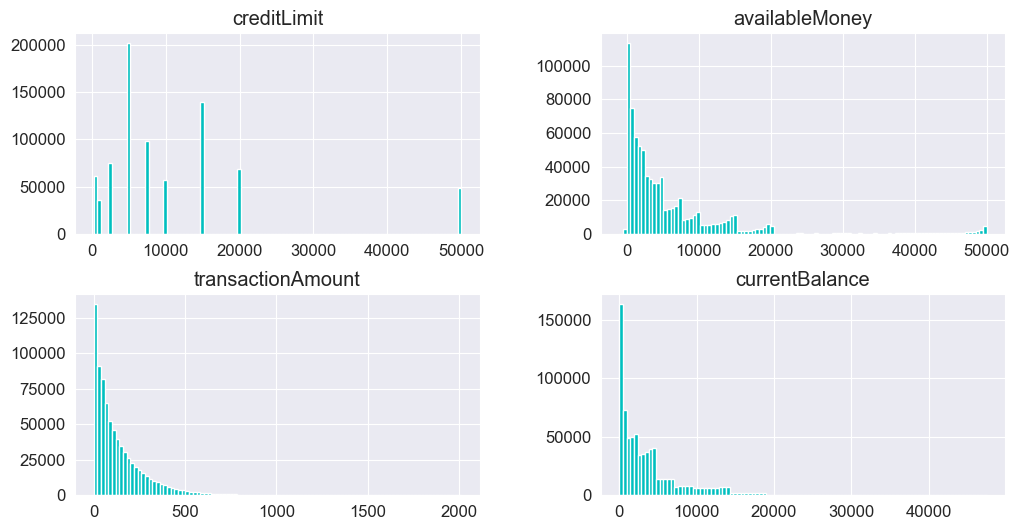

In [51]:
x_num.hist(bins=100,  color='c')

### 2.3 Categorical variables overview

The as-is dataset has 24 non-numerical variables, 4 datetime, 20 categorical/boolean. The post-preprocessed dataset will have 24 categorical variables after we discard the non-informative columns and re-construct the verbose ones. 

- Note 6 columns, ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], are nothing but empty strings, mostly like they do it intentionally to anonymize some geographic and POS tags. We will use the regular expression to convert the empty strings to np.nan. 
- Note the accountNumber and customerId columns are the same. We will drop the customerId column.
- 

In [87]:
# deselect numerical columns and drop the label column
x_cat = df.select_dtypes(exclude='number').drop(labels='isFraud', axis=1)
x_cat.head(10)

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,737265056,737265056,2016-08-13 14:27:32,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,,,,False,,,False
1,737265056,737265056,2016-10-11 05:05:54,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,True,,,False
2,737265056,737265056,2016-11-08 09:18:39,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False
3,737265056,737265056,2016-12-10 02:14:50,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,,,,False,,,False
4,830329091,830329091,2016-03-24 21:04:46,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False
5,830329091,830329091,2016-04-19 16:24:27,In-N-Out #422833,US,US,02,01,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False
6,830329091,830329091,2016-05-21 14:50:35,Krispy Kreme #685312,US,US,02,01,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False
7,830329091,830329091,2016-06-03 00:31:21,Shake Shack #968081,US,US,05,01,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False
8,830329091,830329091,2016-06-10 01:21:46,Burger King #486122,,US,02,01,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False
9,830329091,830329091,2016-07-11 10:47:16,Five Guys #510989,US,US,05,08,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,,,,True,,,False


In [109]:
df[['accountNumber', 'cardLast4Digits','transactionDateTime','creditLimit','cardPresent']].head(100)

,accountNumber,cardLast4Digits,transactionDateTime,creditLimit,cardPresent
0,737265056,1803,2016-08-13 14:27:32,5000.0,False
1,737265056,767,2016-10-11 05:05:54,5000.0,True
2,737265056,767,2016-11-08 09:18:39,5000.0,False
3,737265056,767,2016-12-10 02:14:50,5000.0,False
4,830329091,3143,2016-03-24 21:04:46,5000.0,True
5,830329091,3143,2016-04-19 16:24:27,5000.0,True
6,830329091,3143,2016-05-21 14:50:35,5000.0,True
7,830329091,3143,2016-06-03 00:31:21,5000.0,True
8,830329091,3143,2016-06-10 01:21:46,5000.0,True
9,830329091,3143,2016-07-11 10:47:16,5000.0,True


In [83]:
x_cat.customerId.equals(x_cat.accountNumber)

True

In [82]:
x_cat.accountNumber.value_counts()

accountNumber
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
             ...  
675656700        1
456500351        1
587921563        1
749645399        1
266636812        1
Name: count, Length: 5000, dtype: int64

In [68]:
# replace empty strings with np.nan while downcasting the changed columns' data types
x_cat = x_cat.replace(r'^\s*$', np.nan, regex=True).infer_objects(copy=False)

In [69]:
x_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   transactionDateTime       786363 non-null  object 
 3   merchantName              786363 non-null  object 
 4   acqCountry                781801 non-null  object 
 5   merchantCountryCode       785639 non-null  object 
 6   posEntryMode              782309 non-null  object 
 7   posConditionCode          785954 non-null  object 
 8   merchantCategoryCode      786363 non-null  object 
 9   currentExpDate            786363 non-null  object 
 10  accountOpenDate           786363 non-null  object 
 11  dateOfLastAddressChange   786363 non-null  object 
 12  cardCVV                   786363 non-null  object 
 13  enteredCVV                786363 non-null  o

In [ ]:
Treat the exp date

In [ ]:
last 4 digits with only 3 numbers. Capital One does not issue credit cards in the American Express (Amex) network.

In [ ]:
no idea what echoBuffer is

In [ ]:
posonpremises is legacy pos with physical infrastructure, right?

In [ ]:
The term "expirationdatekeyinmatch" typically refers to a situation where a system or software prompts a user to input or match an expiration date for verification or authentication purposes. It could be part of a security protocol where a user is required to enter a specific expiration date associated with a card, document, or other credential to confirm its validity or access rights. This term is commonly used in contexts such as payment processing, access control systems, or any situation where validating the expiration of a document or credential is necessary.